In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

database = 'database.sqlite'

In [2]:
conn = sqlite3.connect(database)

dd = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
print(dd)

                name
0    sqlite_sequence
1  Player_Attributes
2             Player
3              Match
4             League
5            Country
6               Team
7    Team_Attributes


In [3]:
#player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)

In [4]:
countries = pd.read_sql("""SELECT *
                        FROM Country;""", conn)
countries

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [5]:
leagues = pd.read_sql("""SELECT *
                        FROM League
                        JOIN Country ON Country.id = League.country_id;""", conn)
leagues

,id,country_id,name,id,name
0,1,1,Belgium Jupiler League,1,Belgium
1,1729,1729,England Premier League,1729,England
2,4769,4769,France Ligue 1,4769,France
3,7809,7809,Germany 1. Bundesliga,7809,Germany
4,10257,10257,Italy Serie A,10257,Italy
5,13274,13274,Netherlands Eredivisie,13274,Netherlands
6,15722,15722,Poland Ekstraklasa,15722,Poland
7,17642,17642,Portugal Liga ZON Sagres,17642,Portugal
8,19694,19694,Scotland Premier League,19694,Scotland
9,21518,21518,Spain LIGA BBVA,21518,Spain


In [6]:
df=pd.read_sql_query("SELECT * FROM Player_Attributes", conn)
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.pipeline import make_pipeline

import pickle

In [8]:
target = df.pop('overall_rating')

In [82]:

target.isnull().values.sum()

836

<IPython.core.display.Javascript object>


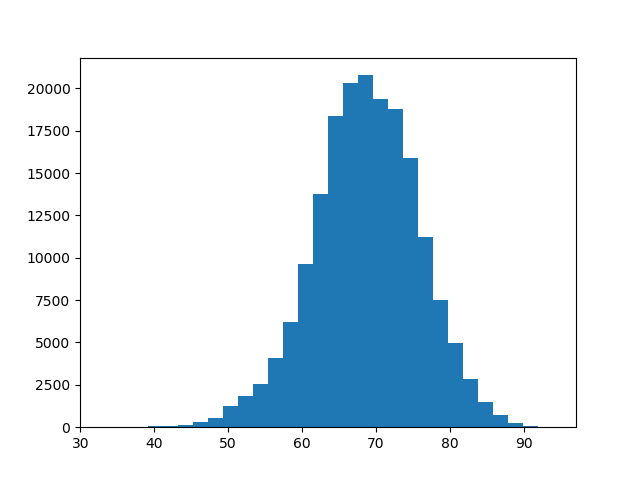

H:\anaconda\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
H:\anaconda\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([7.0000e+00, 6.0000e+00, 2.0000e+01, 6.5000e+01, 9.4000e+01,
        1.4200e+02, 2.9400e+02, 5.2600e+02, 1.2510e+03, 1.8450e+03,
        2.5780e+03, 4.0870e+03, 6.1890e+03, 9.6500e+03, 1.3745e+04,
        1.8366e+04, 2.0310e+04, 2.0773e+04, 1.9382e+04, 1.8784e+04,
        1.5915e+04, 1.1254e+04, 7.5250e+03, 4.9470e+03, 2.8290e+03,
        1.4590e+03, 7.4800e+02, 2.2800e+02, 8.4000e+01, 3.9000e+01]),
 array([33.        , 35.03333333, 37.06666667, 39.1       , 41.13333333,
        43.16666667, 45.2       , 47.23333333, 49.26666667, 51.3       ,
        53.33333333, 55.36666667, 57.4       , 59.43333333, 61.46666667,
        63.5       , 65.53333333, 67.56666667, 69.6       , 71.63333333,
        73.66666667, 75.7       , 77.73333333, 79.76666667, 81.8       ,
        83.83333333, 85.86666667, 87.9       , 89.93333333, 91.96666667,
        94.        ]),
 <a list of 30 Patch objects>)

In [83]:
plt.hist(target, 30)

In [84]:
y = target.fillna(target.mean())

In [85]:
y.isnull().values.any()

False

In [13]:
df.dtypes

id                       int64
player_fifa_api_id       int64
player_api_id            int64
date                    object
potential              float64
preferred_foot          object
attacking_work_rate     object
defensive_work_rate     object
crossing               float64
finishing              float64
heading_accuracy       float64
short_passing          float64
volleys                float64
dribbling              float64
curve                  float64
free_kick_accuracy     float64
long_passing           float64
ball_control           float64
acceleration           float64
sprint_speed           float64
agility                float64
reactions              float64
balance                float64
shot_power             float64
jumping                float64
stamina                float64
strength               float64
long_shots             float64
aggression             float64
interceptions          float64
positioning            float64
vision                 float64
penaltie

In [14]:
df['preferred_foot'] = df['preferred_foot'].astype('category')

In [15]:
ports = {"right": 0, "left": 1}



df['preferred_foot'] = df['preferred_foot'].map(ports)


In [16]:
df['preferred_foot'].isna().values.sum()

836

In [17]:
df['preferred_foot']=df['preferred_foot'].fillna(df['preferred_foot'].mean())

In [18]:
df['preferred_foot'].isnull().values.any()

False

In [19]:
df['preferred_foot']=df['preferred_foot'].astype('int')


In [20]:
df['attacking_work_rate'] = df['attacking_work_rate'].astype('category')

In [21]:
df['attacking_work_rate'].head()

0    medium
1    medium
2    medium
3    medium
4    medium
Name: attacking_work_rate, dtype: category
Categories (8, object): [None, high, le, low, medium, norm, stoc, y]

In [22]:
ports = {"high": 0, "le": 1, "low":2, "medium": 3, "norm": 4, "stoc": 4, "y":5}



df['attacking_work_rate'] = df['attacking_work_rate'].map(ports)


In [23]:
df['attacking_work_rate'].head()

0    3.0
1    3.0
2    3.0
3    3.0
4    3.0
Name: attacking_work_rate, dtype: float64

In [24]:
df['attacking_work_rate']=df['attacking_work_rate'].fillna(df['attacking_work_rate'].mean())

In [25]:
df['attacking_work_rate']=df['attacking_work_rate'].astype('int')

In [26]:
df['attacking_work_rate'].head()

0    3
1    3
2    3
3    3
4    3
Name: attacking_work_rate, dtype: int32

In [27]:
df['defensive_work_rate'] = df['defensive_work_rate'].astype('category')

In [28]:
df['defensive_work_rate'].head()

0    medium
1    medium
2    medium
3    medium
4    medium
Name: defensive_work_rate, dtype: category
Categories (19, object): [0, 1, 2, 3, ..., medium, o, ormal, tocky]

In [86]:
dummy_df = pd.get_dummies(df, columns=['defensive_work_rate'])
dummy_df.head()

,id,player_fifa_api_id,player_api_id,date,potential,preferred_foot,attacking_work_rate,crossing,finishing,heading_accuracy,...,defensive_work_rate_9,defensive_work_rate__0,defensive_work_rate_ean,defensive_work_rate_es,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_o,defensive_work_rate_ormal,defensive_work_rate_tocky
0,1,218353,505942,2016-02-18 00:00:00,71.0,0,3,49.0,44.0,71.0,...,0,0,0,0,0,0,1,0,0,0
1,2,218353,505942,2015-11-19 00:00:00,71.0,0,3,49.0,44.0,71.0,...,0,0,0,0,0,0,1,0,0,0
2,3,218353,505942,2015-09-21 00:00:00,66.0,0,3,49.0,44.0,71.0,...,0,0,0,0,0,0,1,0,0,0
3,4,218353,505942,2015-03-20 00:00:00,65.0,0,3,48.0,43.0,70.0,...,0,0,0,0,0,0,1,0,0,0
4,5,218353,505942,2007-02-22 00:00:00,65.0,0,3,48.0,43.0,70.0,...,0,0,0,0,0,0,1,0,0,0


In [87]:

X = dummy_df.drop(['id', 'date'], axis=1)

In [88]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X=scaler.fit_transform(X)

H:\anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
H:\anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [92]:
#imputing null value of each column with the mean of that column
imput = Imputer()
X_train = imput.fit_transform(X_train)
X_test = imput.fit_transform(X_test)

H:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [93]:
from sklearn.linear_model import Ridge
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
ridge = Ridge(alpha=1).fit(X_train, y_train)
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)


In [94]:
grid.fit(X_train,y_train)

H:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    3.7s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

In [95]:
grid.best_params_


{'alpha': 10}

In [96]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression(fit_intercept=False)
lm.fit(X_train,y_train )

# print intercept and coefficients


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)

In [97]:
lm.predict(X_test)

array([  2.31457086,  -4.73076695,  -0.15209323, ...,  -2.57305164,
         2.34383791, -12.01561296])

In [98]:
lm.score(X_train,y_train)

-94.7560409615157

In [99]:
lm.score(X_test,y_test)

-93.75479872383266

In [101]:
new_model=XGBRegressor(learning_rate= 1, max_depth= 5, n_estimators= 50)
new_model.fit(X_train,y_train)

H:\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:59:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [102]:
new_model.score(X_train,y_train)

0.9523195403155694

In [103]:
new_model.score(X_test,y_test)

0.9397227047804344

In [108]:
new_model.predict(X_test)

array([74.31971, 64.64192, 68.67069, ..., 64.26308, 74.65321, 56.08947],
      dtype=float32)

In [106]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor()
clf.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [107]:
clf.predict(X_test)

array([74., 67., 70., ..., 66., 73., 56.])

In [109]:
clf.score(X_test,y_test)

0.9610810489030357

In [110]:
clf.score(X_train,y_train)

0.9994180413843973

By accuracy comparision performed above Decision tree gives better result than any other model. and it can predict the target function with approx 99.9% train accuracy and 96%test accuracy